In [24]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False
num_products = env_1_sale_args['num_products']

In [9]:
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

num_users = 100
data_sm = deepcopy(env).generate_logs(num_users)
display(data_sm)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.28it/s]


,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,0,<NA>,NaN,NaN,NaN,None
1,1.0,0,organic,9,<NA>,NaN,NaN,NaN,None
2,2.0,0,organic,0,<NA>,NaN,NaN,NaN,None
3,3.0,0,organic,0,<NA>,NaN,NaN,NaN,None
4,4.0,0,organic,9,<NA>,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
8955,128.0,99,bandit,<NA>,2,0.0,0.0,0.1,()
8956,129.0,99,bandit,<NA>,5,0.0,0.0,0.1,()
8957,130.0,99,bandit,<NA>,2,0.0,0.0,0.1,()
8958,131.0,99,bandit,<NA>,5,0.0,0.0,0.1,()


## Build training set

In [12]:
# num_users = 10000
# data = deepcopy(env).generate_logs(num_users)
data = data_sm

 ### Only attribute reward if the recommended product is sold before the next clicked recommendation

In [13]:
def build_data_clicked_v1(data):
    # List indices that correspond to clicks
    clicked_indices = list(data.loc[data["c"]==1].index)

    # Only keep clicked rows
    data_clicked = data.loc[data["c"]==1]
    data_clicked["y"] = 0

    last_user_clicked = list(data.loc[data["u"]==data.iloc[clicked_indices[len(clicked_indices)-1]].loc["u"]].index)
    last_user_clicked = last_user_clicked[len(last_user_clicked)-1] +1

    # add one value to clicked indices : the last row for the last user who clicked
    clicked_indices += [last_user_clicked]

    for i in range(len(clicked_indices)-1):
        # Only keep the indices before the next time the user clicks
        data_slice = data.iloc[clicked_indices[i]:clicked_indices[i+1]]
        # Only keep the observations for the same user
        data_slice.loc[data_slice["u"]==data_slice["u"].iloc[0]]

        # Count the number of times a sale for the recommended product is observed in the time frame of interest
        data_clicked["y"].iloc[i] = len(data_slice.loc[(data_slice["z"]=="sale") & (data_slice["v"]==data_slice["a"].iloc[0])])
    return data_clicked

In [14]:
data_clicked = build_data_clicked_v1(data)

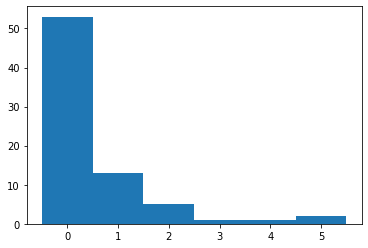

In [15]:
plt.hist(data_clicked["y"], bins = np.array(sorted(list(data_clicked["y"].unique())+[max(data_clicked["y"])+1]))-0.5)
plt.show()

### Attribute a reward if the product was sold later at one point during the user session

--> Question : what to do in case of several recommendations for the same product ? 

---> attribute it to the last time it was recommended

For each user : look at every sale, find the last time it was recommended (if any), and give reward

In [16]:
def build_data_clicked_v2(data):
    from tqdm import tqdm
    sales_indices = list(data.loc[data["c"]==1].index)
    data_clicked2 = data.loc[data["c"]==1]
    data_clicked2["y"] = 0
    
    # Loop over users
    for u in tqdm(data["u"].unique()):
        # Create dataframe with current user
        data_u = data.loc[data["u"]==u]
        # Keep track of indices of sales, and corresponding products
        sales = {"index":data_u.loc[data["z"]=="sale"].index,
                 "product":list(data_u.loc[data["z"]=="sale"]["v"])}
        # Loop over sales
        for i in range(len(sales["index"])):
            # Create dataframe that includes everything up until the sale
            data_slice = data_u.iloc[:sales["index"][i]]
            # Only keep clicked recos that correspond to the sold product
            data_recos = data_slice.loc[(data_slice["c"]==1) & (data_slice["a"]==sales["product"][i])]
            if len(data_recos) > 0 :
                index = data_recos.index[len(data_recos.index)-1]
                data_clicked2["y"].loc[data_clicked2.index == index] = data_clicked2["y"].loc[data_clicked2.index == index] + 1
    return data_clicked2

In [18]:
data_clicked2 = build_data_clicked_v2(data)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.41it/s]


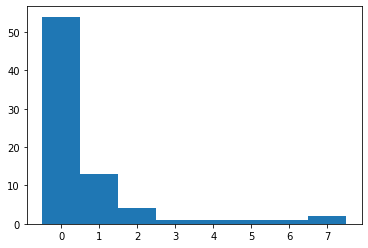

In [19]:
plt.hist(data_clicked2["y"], bins = np.array(sorted(list(data_clicked2["y"].unique())+[max(data_clicked2["y"])+1]))-0.5)
plt.show()

In [293]:
# def build_user_states(data_clicked, data):
#     features = []
#     for u in tqdm(data_clicked["u"].unique()):
#         view_feature = [sum(data[(data["u"]==u) & (data["z"]=="organic")]["v"]==p) for p in range(num_products)]
#         click_feature = [sum(data[(data["u"]==u) & (data["c"]==1)]["a"]==p) for p in range(num_products)]
# #         print(u)
# #         print(features)
# #         print(list(view_feature+click_feature)*sum(data_clicked["u"]==u))
#         features = features + [view_feature+click_feature]*sum(data_clicked["u"]==u)
#     return np.array(features)

In [33]:
def build_user_states(data_clicked, data):
    features = []
    for u in tqdm(data_clicked["u"].unique()):
        for index in data_clicked[data_clicked["u"]==u].index : 
            view_feature = [sum(data.iloc[:index].loc[(data["u"]==u) & (data["z"]=="organic")]["v"]==p) for p in range(num_products)]
            click_feature = [sum(data.iloc[:index].loc[(data["u"]==u) & (data["c"]==1)]["a"]==p)/np.clip(sum(data.iloc[:index].loc[(data["u"]==u) & (data["z"]=="bandit")]["a"]==p),a_min=1,a_max=np.Infinity) for p in range(num_products)]
            features = features + [view_feature+click_feature]
    return np.array(features)

In [34]:
def build_training_set(data, version = "v1", features = None):
    if version == "v1":
        data_clicked = build_data_clicked_v1(data)
    else :
        data_clicked = build_data_clicked_v2(data)
    if features is None :
        user_states = build_user_states(data_clicked, data)
    else :
        user_states = features
    actions, rewards, proba_actions = tuple(data_clicked["a"]), np.array(data_clicked["y"]), np.array(data_clicked["ps"])
    return user_states, actions, rewards, proba_actions

In [35]:
train1 = build_training_set(data_sm, version = "v1")
user_states, actions, rewards, proba_actions = train1
# train2 = build_training_set(data_sm, version = "v2")

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:08<00:00,  5.13it/s]


In [362]:
from recogym.agents import Agent, FeatureProvider
from numpy.random.mtrand import RandomState
from sklearn.linear_model import LogisticRegression
# import pandas as pd
from copy import deepcopy
from scipy.stats.distributions import beta
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from recogym.util import FullBatchLBFGS

In [326]:
class LikelihoodAgentModif(Agent):
    def __init__(self, epsilon_greedy = False, epsilon = 0.3, seed=43):
        self.random_state = RandomState(seed)
        self.model = None
        self.epsilon_greedy = epsilon_greedy
        self.epsilon = epsilon
    
    def _create_features(self, logs, train_version = "v1"):
        user_states, actions, rewards, proba_actions = build_training_set(logs, train_version)
        rewards = (rewards > 0)*1
        return user_states, actions, rewards, proba_actions
        
    def train(self, user_states, actions, rewards, proba_actions):
        features = np.concatenate([user_states,np.array(actions).reshape(len(actions),1)],axis=1)
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)

    

In [349]:
data_clicked

,t,u,z,v,a,c,r,ps,ps-a,y
121,98.0,1,bandit,<NA>,3,1.0,0.0,0.1,(),2
374,173.0,2,bandit,<NA>,5,1.0,0.0,0.1,(),2
678,39.0,7,bandit,<NA>,3,1.0,0.0,0.1,(),0
718,6.0,8,bandit,<NA>,4,1.0,0.0,0.1,(),5
1093,123.0,11,bandit,<NA>,2,1.0,0.0,0.1,(),0
...,...,...,...,...,...,...,...,...,...,...
1036278,99.0,9988,bandit,<NA>,7,1.0,2.0,0.1,(),2
1036488,114.0,9991,bandit,<NA>,3,1.0,0.0,0.1,(),0
1036689,52.0,9994,bandit,<NA>,0,1.0,0.0,0.1,(),0
1036693,56.0,9994,bandit,<NA>,0,1.0,3.0,0.1,(),1


In [346]:
agent = LikelihoodAgentModif()

In [332]:
agent.train(user_states, actions, rewards, proba_actions)

In [364]:
# test=verify_agents_sale(
#     env,
#     number_of_users=2000,
#     agents={
#         'likelihood modif': agent
#     }
# )